In [1]:
!pip install unidecode # unidecode 패키지 다운로드

import unidecode

# Figure1 참고
# 이걸 실행하면 링크와 함께 무슨 authentication code를 넣으라고 칸이 뜬다.
# 링크 누르고 계정 엑세스 하는걸 허용해 준 다음 링크를 복사해서 칸에 입력하면 된다.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# tf_data의 사용법에 대해서 살펴보자. 

## 데이터 읽어오기

In [2]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

trainPath = '/content/drive/My Drive/Colab Notebooks/data/cifar/train/*.png'
testPath = '/content/drive/My Drive/Colab Notebooks/data/cifar/test/*.png' 
trainDataPaths = glob(trainPath)
testDataPaths = glob(testPath)

print("[*] 데이터 경로 확인")
print(f"   [-] train data : {len(trainDataPaths)}")
print(f"   [-] train data sample: {trainDataPaths[0]}")
print(f"   [-] test data : {len(testDataPaths)}")
print(f"   [-] train data sample: {testDataPaths[0]}")

[*] 데이터 경로 확인
   [-] train data : 50000
   [-] train data sample: /content/drive/My Drive/Colab Notebooks/data/cifar/train/7202_frog.png
   [-] test data : 10000
   [-] train data sample: /content/drive/My Drive/Colab Notebooks/data/cifar/test/1524_cat.png


## 이미지 데이터 보기

[*] 샘플 데이터 이미지 확인
    [-] shape : (32, 32, 3)


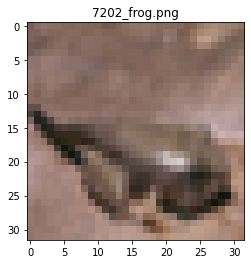

In [3]:
testPath = trainDataPaths[0]
gfile = tf.io.read_file(testPath)
image = tf.io.decode_image(gfile)
print(f"[*] 샘플 데이터 이미지 확인")
print(f"    [-] shape : {image.shape}")
plt.title(os.path.basename(testPath))
plt.imshow(image)
plt.show()

## tf_data 사용을 위한 전처리 단계 

In [4]:
def read_image(path):
  gfile = tf.io.read_file(path)
  image = tf.io.decode_image(gfile)
  return image

def get_label(path):
  return path.split('_')[-1].replace('.png', '')

label_name = [get_label(path) for path in trainDataPaths]     # trainDataPaths에 저장되어있는 경로들에서 라벨을 추출
class_names = np.unique(label_name)                           # 중복 제거를 통해서 class_names 생성

def onehot_encoding(label):
  return np.array(class_name == label, np.uint8)

def read_image_label(path, label):
  gfile = tf.io.read_file(path)
  image = tf.io.decode_image(gfile)
  return image, label

def get_label_tensor(path):
  fname = tf.strings.split(path, '_')[-1]
  cls_name = tf.strings.regex_replace(fname, '.png', '')
  onehot_encoding = tf.cast(class_name == cls_name, tf.uint8)
  return onehot_encoding

우리는 라벨값을 얻는데 두가지 함수를 사용하였다. 
 - `split()` : python 내장 함수 + `np.array()` : numpy 내장 함수
 - `tf.string.split()` : tensorflow 내장 함수 + `tf.cast` : tensorflow 내장 함수

어떤 방법이 더 좋은 방법일까? 

검색을 해보니 일단 `tf.string.split()` 함수는 정규식도 지원하는 것으로 보인다. 이 함수의 입력 인자에 대한 설명은 다음과 같다.

`tf.strings.split(input, sep=None, maxsplit=-1, name=None)`
 - `input` : A string Tensor of rank N, the strings to split. If rank(input) is not known statically, then it is assumed to be 1.
 - `sep` : 0-D string Tensor, the delimiter string.
 - `maxsplit` : An int. If maxsplit > 0, limit of the split of the result.
 - `name` : A name for the operation (optional).

즉 `tf.string.split` 함수가 `split`보다 조금 더 많은 기능을 지원한다. `np.array()`와 `tf.cast()`는 크게 차이가 없어 보인다. 자신에게 더 맞는 아무거나 사용하면 될 것 같다. 

### tf.data.Dataset.from_tensor_slices(filenames)

파일들을 불러들여 tensor를 생성하는 함수.

In [ ]:
batch_size = 8
dataset = tf.data.Dataset.from_tensor_slices(trainDataPaths)    # 해당 경로들을 모두 텐서로 생성
dataset = dataset.map(read_image)                               # 각 경로들을 읽어서 이미지로 변환
dataset = dataset.batch(batch_size=batch_size)                  # 읽은 모든 데이터를 batch_size 만큼으로 분리
tf_image = next(iter(dataset))
print(f"생성한 dataset shape : {tf_image.shape}")

### shuffle 

불러들인 데이터의 순서을 무작위로 섞는다. 단 이 메소드를 사용할 경우 시간이 오래걸린다.

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(trainDataPaths)    # 해당 경로들을 모두 텐서로 생성
dataset = dataset.map(read_image)                               # 각 경로들을 읽어서 이미지로 변환
dataset = dataset.batch(batch_size=batch_size)                  # 읽은 모든 데이터를 batch_size 만큼으로 분리
dataset = dataset.shuffle(buffer_size = len(trainDataPaths))    # 버퍼 사이즈 만큼의 데이터를 랜덤으로 섞는다.
tf_image = next(iter(dataset))
print(f"생성한 dataset shape : {tf_image.shape}")

생성한 dataset shape : (8, 32, 32, 3)


### repeat

데이터 셋을 반복한다. 

In [9]:
label_names = [get_label(path) for path in trainDataPaths]     # trainDataPaths에 저장되어있는 경로들에서 라벨을 추출

dataset = tf.data.Dataset.from_tensor_slices((trainDataPaths, label_names))
dataset = dataset.map(read_image_label)
dataset = dataset.batch(batch_size = batch_size)
dataset = dataset.repeat()
image, label = next(iter(dataset))
print(f'image shape : {image.shape}')
print(f'label shape : {label.shape}')

image shape : (8, 32, 32, 3)
label shape : (8,)


## fit with tf.data

### 사용할 함수들 정의

In [32]:
def get_class_name(path):
  fname = tf.strings.split(path, '_')[-1]
  lbl_name = tf.strings.regex_replace(fname, '.png', '')
  return lbl_name

class_names = [get_class_name(path) for path in trainDataPaths]
classes = tf.unique(class_names).y.numpy()

def onehot_encoding_function(path):
  onehot_encoding = tf.cast(classes == get_class_name(path), tf.uint8)
  return onehot_encoding

def read_dataset(path):
  gfile = tf.io.read_file(path)
  image = tf.io.decode_image(gfile)

  image = tf.cast(image, tf.float32) / 255.

  label = onehot_encoding_function(path)

  return image, label

def image_preprocess(image, label):
  image = tf.image.random_flip_left_right(image)      # 이미지를 랜덤으로 왼쪽 오른쪽으로 뒤집는다.
  image = tf.image.random_flip_up_down(image)         # 이미지를 랜덤으로 위 아래로 뒤집는다.
  return image, label

### 하이퍼 파라미터 정의

In [28]:
num_epochs = 10
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (32,32,3)
num_classes = 10

### 데이터셋 불러오기

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices(trainDataPaths)
train_dataset = train_dataset.map(read_dataset)
train_dataset = train_dataset.map(image_preprocess)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(testDataPaths)
test_dataset = test_dataset.map(read_dataset)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

### 모델 정의

In [36]:
from tensorflow.keras import layers
from tensorflow.keras import datasets 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

inputs = layers.Input(input_shape)
net = layers.Conv2D(32, (3,3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size = (2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs = inputs, outputs = net, name = 'Basic_CNN')

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [39]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0 

In [38]:
model.fit_generator(
    train_dataset,
    steps_per_epoch = len(trainDataPaths) // batch_size,
    validation_data = test_dataset,
    validation_steps = len(testDataPaths) // batch_size,
    epochs = num_epochs
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1562/1562 [==============================] - 1680s 1s/step - loss: 1.7099 - accuracy: 0.3550 - val_loss: 1.3756 - val_accuracy: 0.4867
Epoch 2/10
1562/1562 [==============================] - 362s 232ms/step - loss: 1.4160 - accuracy: 0.4783 - val_loss: 1.2161 - val_accuracy: 0.5551
Epoch 3/10
1562/1562 [==============================] - 363s 233ms/step - loss: 1.3070 - accuracy: 0.5241 - val_loss: 1.1166 - val_accuracy: 0.5984
Epoch 4/10
1562/1562 [==============================] - 364s 233ms/step - loss: 1.2323 - accuracy: 0.5543 - val_loss: 1.0851 - val_accuracy: 0.6103
Epoch 5/10
1562/1562 [==============================] - 362s 232ms/step - loss: 1.1915 - accuracy: 0.5711 - val_loss: 1.0540 - val_accuracy: 0.6231
Epoch 6/10
1562/1562 [==============================] - 362s 232ms/step - loss: 1.1545 - accuracy: 0.5885 - val_loss: 1.0250 - val_accuracy: 0.6363
Epoch 7/10
1562/1562 [==============================] - 363s 232ms/step - loss: 1.1279 - accuracy: 0.5980 - val_lo

# callbacks에 대해서 알아보자.

모델을 훈련시키는 일은 대체적으로 오랜 시간이 걸린다. AI 개발자가 훈련을 따다 끝날때 까지 가만히 앉아서 잘 학습이 되기를 기도하는 것은 너무 불안한 일이다. 그래서 Tensorflow는 모델을 훈련시키는 동안 어떤 이벤트들이 발생하면 개발자가 원하는 동작을 수행할 수 있는 방법을 제공하고 있다. 

## LambdaCallback

Callback을 새롭게 만들어 쓰고는 싶은데 전체 클래스를 새로 만들기에는 부담스러울 때가 존재한다. 이때 Callback을 함수 형태로 전달할 수 있게 해주는 것이 LambdaCallback이다.

In [42]:
# https://www.tensorflow.org/tensorboard/r2/image_summaries

from datetime import datetime

import sklearn.metrics
import itertools
import io
logdir = os.path.join('/content/drive/My Drive/Colab Notebooks/logs', datetime.now().strftime('%Y%m%d-%H%M%S'))
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [43]:
test_images, test_labels = next(iter(test_dataset))  # Confusion Matrix 그릴 때 필요한 Test Image


def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [44]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
 model.fit_generator(
    train_dataset, 
    steps_per_epoch = len(trainDataPaths) // batch_size,
    validation_data = test_dataset,
    validation_steps = len(testDataPaths) // batch_size,
    epochs = num_epochs,
    callbacks=[cm_callback]
)